# Time Dependent Schrödinger's Equation

## Development

### Schrödinger's Equation

Shrödinger's Equation reads:

$i\hbar\,\frac{\partial\psi}{\partial t}=\frac{-\hbar^2}{2m}\,\frac{\partial^2\psi}{\partial x^2}+V\cdot\psi$

The goal of this program is to numerically solve this equation.

___

### Finite Difference Method

Given a function $f(x)$ we can expand $f(x+\Delta x)$ through a Taylor Series expantion about x:

$\textstyle f(x+\Delta x) = f(x) + \Delta x\cdot f'(x) + \mathcal{O}(\Delta x^2)$

so we can define the **first forward finite difference** as:

$f'_+\approx \frac{f(x + \Delta x)-f(x)}{\Delta x}$

similarly, by expanding $f(x-\Delta x)$, we define de **first backwards finite difference**:

$f'_-\approx \frac{f(x)-f(x - \Delta x)}{\Delta x}$

from this we can approximate the second derivative $f''(x)$ by:

$f''(x) \approx \frac{f'_+(x)-f'_-(x)}{\Delta x} = \frac{\frac{f(x + \Delta x)-f(x)}{\Delta x}-\frac{f(x)-f(x - \Delta x)}{\Delta x}}{\Delta x} = \frac{f(x+\Delta x)-2\cdot f(x) + f(x-\Delta x)}{\Delta x^2}$

___

### Numerical Solution to Schrödinger's Equation

If the particle is contained within a finite region of lenght $L$, we can subdivide the region on $N_x$ subitnervals of lenght $\Delta x = \frac{L}{N}$, such that we define the points:

$0,\,\Delta x,\,2\cdot\Delta x,\,3\cdot\Delta x,\,\dots,\,(N_x-1)\cdot\Delta x,\,L$

or

$\displaystyle x_0,\,x_1,\,x_2,\,\dots,\,x_{N_x-1},\,x_{N_x}$

Similarlly, if we are interested in the evolution of the particle in the time interval from $t_0$ to $t_f$, by dividing the interval in $N_t$ steps, we get a step size of $\Delta t = \frac{t_f-t_0}{N_t}$. Thus, we would have the set of time points:

$t_0,\,t_0+\Delta t,\,t_0+2\Delta t,\,t_0+3\Delta t,\dots,\,t_0+(N_t-1)\Delta t,\,t_f$

or

$\displaystyle t_0,\,t_1,\,t_2,\,\dots,\,t_{N_t-1},\,t_{N_t}$

TBy employing finite differences, and defining $\psi_{i,j} := \psi(x_i,t_j)$, Schrödinger's Equation can be written as:

$\displaystyle i\hbar \left(\frac{\psi_{i,j+1}-\psi_{i,j}}{\Delta t}\right) = \frac{-\hbar^2}{2m}\left(\frac{\psi_{i+1,j}-2\cdot\psi_{i,j}+\psi_{i-1,j}}{\Delta x^2}\right) + V_{i,j}\cdot\psi_{i,j}$

so that we can write the following requrance relation:

$\displaystyle \psi_{i,j+1} = \frac{\Delta t}{i\hbar}\left[\frac{-\hbar^2}{2m}\left(\frac{\psi_{i+1,j}-2\cdot\psi_{i,j}+\psi_{i-1,j}}{\Delta x^2}\right) + V_{i,j}\cdot\psi_{i,j}\right]+\psi_{i,j}$

Thus, given a defined initial state $\psi_{i,0}$ with $(0\leq i \leq N_x)$, we can employ the recurrance relation to calculate the state at an arbitrary subsequent time. The initial state we will employ is the result of the time-independent code.

___
___


## Code

### Setup

**Importing Libraries**

In [10]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate as integrate

**Physical Constants**

In [11]:
hbar = 1  # reduced plank's constant
m = 1     # particle's mass

**Problem Parameters**

In [12]:
final_t = 300
steps = 500001

In [13]:
phis = np.load("ti_wf.npy",allow_pickle=True)                   # importing the results of the time-independent program
xs = phis.item().get("xs")                                      # defining the spacial evaluation points
ts = np.linspace(0, final_t, steps,dtype=np.float64)            # defining the time evaluation points

a = xs[0]                                                       # lower space bound
b = xs[-1]                                                      # upper space bound

Nx = xs.shape[0]                                                # number of space intervals
Nt = ts.shape[0]                                                # number of time intervals

dx = xs[1]-xs[0]                                                # spacial step size
dt = ts[1]-ts[0]                                                # time step size

**Potential**

In [14]:
# Definition of the potential function

def potential(x,t):
    k = 1/10
    P = 0
    # if (a) < x < (b):
    #     P += 0
    # else:
    #     P += 1e20
    P += np.exp(-(x/k)**2)*np.exp(-((t-1)/k)**2, dtype=np.complex256)
    return P

potential(1,0)

(1.383896526736737589e-87+0j)

### Finite Difference Method

**Potential Energy**

In [15]:
V = np.zeros_like(np.outer(xs,ts), dtype=np.complex256)

for i,row in enumerate(V):
    for j,col in enumerate(row):
        V[i,j] = potential(xs[i],ts[j])

**Algorithm**

In [16]:
wf = pd.DataFrame(index=ts,columns=xs)
phi1 =(phis.item().get(3)).astype(np.complex256)

for j in range(Nt):
    if j == 0:
        wf.iloc[0] = (phi1*np.conj(phi1)).real
    else:
        phi2 = np.zeros_like(phi1,dtype=np.complex256)
        for i,val in enumerate(phi2):
            if (i==0) or (i >= (Nx-1)):
                phi2[i] = 0
            else:
                phi2[i] = dt/(1j*hbar)*(-hbar**2/(2*m*dx**2)*(phi1[i+1]-2*phi1[i]+phi1[i-1])+V[i,j]*phi1[i]) + phi1[i]
        norm = integrate.simpson((phi2*np.conj(phi2)).real,xs)
        phi2 = phi2/np.sqrt(norm)
        wf.iloc[j] = np.round((phi2*np.conj(phi2)).real,20)
        phi1 = phi2


### Animation

**Animation Function**

In [17]:
fr = 10000

def aniFunc(i):
    plt.clf()
    a = wf.iloc[int(i*Nt/fr)].to_numpy()
    plt.plot(xs,a)
    plt.plot(xs,V[:,int(i*Nt/fr)].real)
    plt.xlabel(r'$x$')
    plt.suptitle(r'$E_4$')
    plt.title(r't = {0:.3f}'.format(np.round(ts[int(i*Nt/fr)],3)))
    plt.legend(['$|\Psi|^2$','V'])
    plt.grid()
    plt.xlim([-11,11])
    plt.ylim([-0.01,0.15])

**Generate Animation**

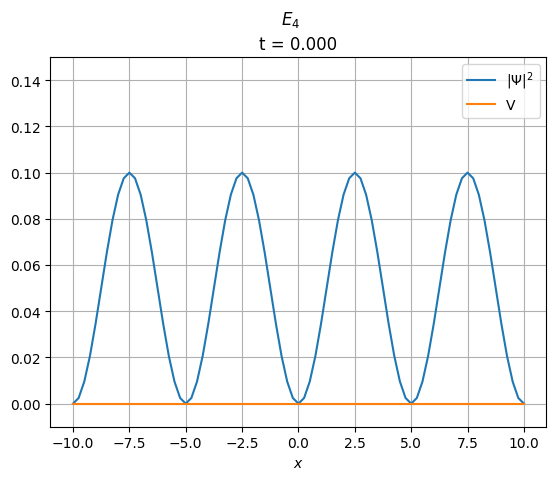

In [18]:
plt.rcParams['animation.embed_limit'] = 2**128
figure, ax1 = plt.subplots()
anim = animation.FuncAnimation(figure, func=aniFunc,frames=fr,interval=1)

# from IPython.display import HTML
# HTML(anim.to_jshtml())
writervideo = animation.FFMpegWriter(fps=160)
anim.save('E4.mp4', writer=writervideo)